In [ ]:
!pip install GDAL
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 46.4 MB/s eta 0:00:00


In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy
from scipy.interpolate import interp1d

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# dataset = gdal.Open(f'/content/gdrive/MyDrive/Species_distributions/Richness_10km_AMPHIBIANS_dec2017_EckertIV.tif')
dataset = gdal.Open(f'/content/gdrive/MyDrive/Species_distributions/Richness_10km_Birds_v7_EckertIV_Passeriformes.tif')

In [ ]:
dataset.RasterCount

1

In [ ]:
proj = dataset.GetProjection()
print(proj)

PROJCS["World_Eckert_IV",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Eckert_IV"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [ ]:
GT = dataset.GetGeoTransform()
print(GT)

(-16671202.0, 10000.0, 0.0, 8381472.0, 0.0, -10000.0)


In [ ]:
band = dataset.GetRasterBand(1)

In [ ]:
b = band.ReadAsArray()
# For mammals and amphibians
# msk_array = np.ma.masked_equal(b, value = 255)
# For birds
msk_array = np.ma.masked_equal(b, value = 65535)

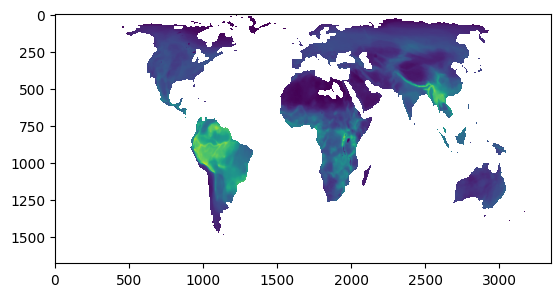

In [ ]:
plt.imshow(msk_array)
plt.show()

In [ ]:
dataset.RasterXSize

3349

In [ ]:
X_pixel = np.array([i for i in range(dataset.RasterXSize)])
Y_line = np.array([i for i in range(dataset.RasterYSize)])


X_geo = np.zeros((dataset.RasterXSize, dataset.RasterYSize))
Y_geo = np.zeros((dataset.RasterXSize, dataset.RasterYSize))

for i in tqdm(range(dataset.RasterXSize)):
  for j in range(dataset.RasterYSize):
    X_geo[i,j] = GT[0] + X_pixel[i] * GT[1] + Y_line[j] * GT[2]
    Y_geo[i,j] = GT[3] + X_pixel[i] * GT[4] + Y_line[j] * GT[5]

100%|██████████| 3349/3349 [01:16<00:00, 44.05it/s]


In [ ]:
np.max(msk_array)

395

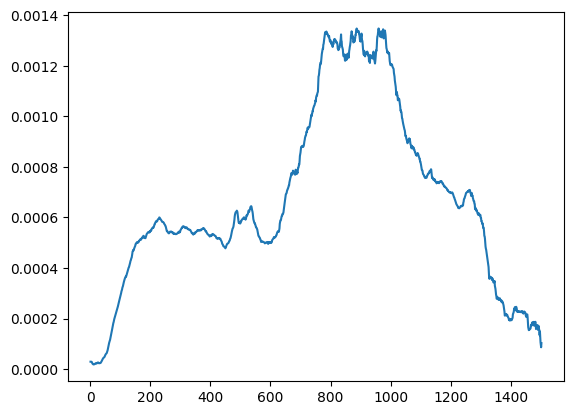

In [ ]:
plt.plot(np.mean(msk_array, axis = 1)/np.sum(np.mean(msk_array, axis = 1)))
plt.show()

100%|██████████| 1680/1680 [01:16<00:00, 21.90it/s]


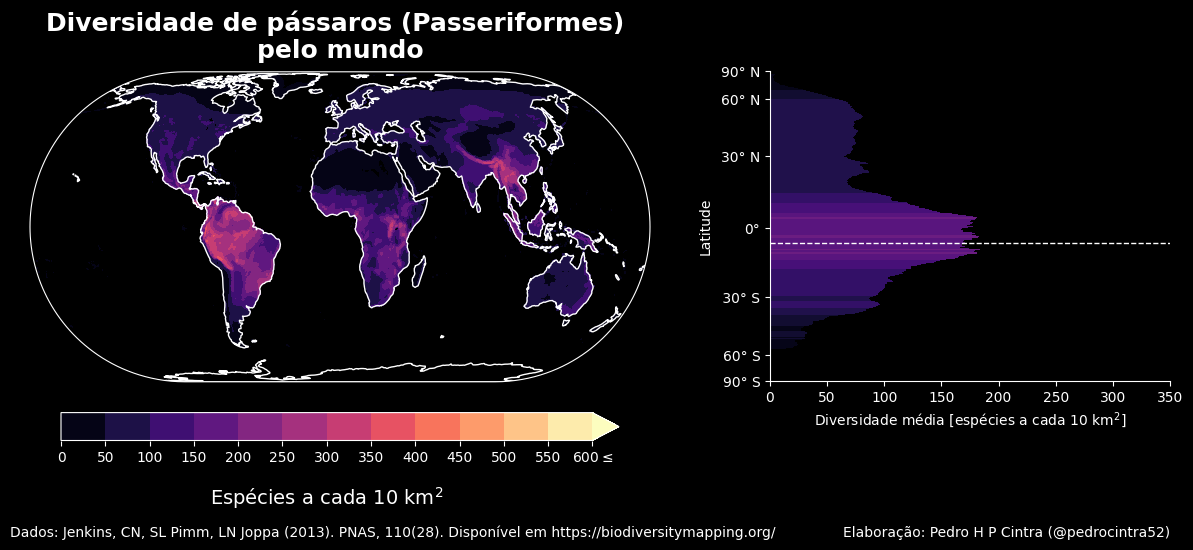

In [ ]:
lev = 20

projection = ccrs.EckertIV()
projection_name = 'EckertIV'

fig = plt.figure(figsize = (8, 8))

#####################################################
# TOP LEFT PLOT
#####################################################

#Add an axes to the current figure and make it the current axes.
ax = plt.subplot(111, projection = projection)

#make the map global rather than having it zoom in to extent of the plotted data
ax.set_global()

# ax.gridlines(linestyle = "--", color = "white", lw = 0.5)

ax.add_feature(cartopy.feature.LAND, facecolor='none', zorder = 2, edgecolor = 'white')

heat = ax.contourf(X_geo.T, Y_geo.T, msk_array, [50*i for i in range(13)], cmap = 'magma', extend = "max")
cb = plt.colorbar(heat, ax = ax,
                  orientation = "horizontal",
                  pad = 0.05,
                  aspect = 20,  #ratio of long to short dimension
                  shrink = 0.9)
cb.set_label(r"Espécies a cada 10 km$^2$", size = 14, rotation = 0, labelpad = 15,
            color = 'white')
cb.set_ticks([50*i for i in range(13)])
cb.set_ticklabels([50*i if i < 12 else r"600$\leq$" for i in range(13)], color = 'white')
cb.ax.tick_params(labelsize = 10, color = 'white')

# ax.add_feature(cartopy.feature.OCEAN, facecolor='black', zorder = 2)

plt.title("Diversidade de pássaros (Passeriformes) \npelo mundo", fontsize = 18, pad = 10, weight = 'bold',
          color = 'white')


#############################################################################
# RIGHT PLOT
#############################################################################

kwargs = dict(position = (1.05,0.265,0.5,0.387))
ax2 = fig.add_subplot(122, **kwargs)

for i in tqdm(range(dataset.RasterYSize)):
  try:
    plt.barh(Y_line[-i], np.mean(msk_array, axis = 1)[i], color = sns.color_palette('magma', lev+1)[min(lev,int(lev*np.mean(msk_array, axis = 1)[i]/600))],
            align = 'edge', height = Y_line[1] - Y_line[0])
  except:
    continue

# For Mammals and Amphibians
# ax2.set_ylim(-160, dataset.RasterYSize*1.01)
# ax2.set_yticks([-160, -15.5, 0.195*dataset.RasterYSize, 0.45*dataset.RasterYSize,
#                 0.704*dataset.RasterYSize, 0.912*dataset.RasterYSize, dataset.RasterYSize*1.01])
# For Birds
ax2.set_ylim(0, dataset.RasterYSize*1.01)
ax2.set_yticks([0, 0.085*dataset.RasterYSize, 0.275*dataset.RasterYSize, 0.5*dataset.RasterYSize,
                0.735*dataset.RasterYSize, 0.92*dataset.RasterYSize, dataset.RasterYSize*1.01])
ax2.set_yticklabels(["90° S", "60° S"," 30° S", "0°", "30° N", "60° N", "90° N"], color = 'white')
ax2.set_xticks([0,50,100,150,200,250,300,350])
ax2.set_xticklabels([0,50,100,150,200,250,300,350], color = 'white')
ax2.set_ylabel("Latitude", color = 'white')
ax2.set_xlabel(r"Diversidade média [espécies a cada 10 km$^2$]", color = 'white')
ax2.axhline(0.45*dataset.RasterYSize, lw = 1, ls = '--', color = 'white', zorder = 2)
ax2.spines[['right','top']].set_visible(False)
ax2.tick_params(axis='both', color='white')
for spine in ax2.spines.values():
  spine.set_edgecolor('white')

fig.patch.set_facecolor('black')
for ax in fig.axes:
  ax.patch.set_facecolor('black')
  for spine in ax.spines.values():
        spine.set_edgecolor('white')

fig.text(0.1,0.07, "Dados: Jenkins, CN, SL Pimm, LN Joppa (2013). PNAS, 110(28). Disponível em https://biodiversitymapping.org/", color = 'white')
fig.text(1.55, 0.07, "Elaboração: Pedro H P Cintra (@pedrocintra52)", color = 'white', ha = 'right')
plt.savefig(f"Passeriformes_species_world_magma_{projection_name}.png", dpi = 300, bbox_inches = 'tight')

plt.show()

In [ ]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<ipython-input-23-fb56bf95bef3>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [ ]:
# Robinson
# code = "ESRI:54030"
# EckertIV
code = "ESRI:54012"
world = world.to_crs(code)

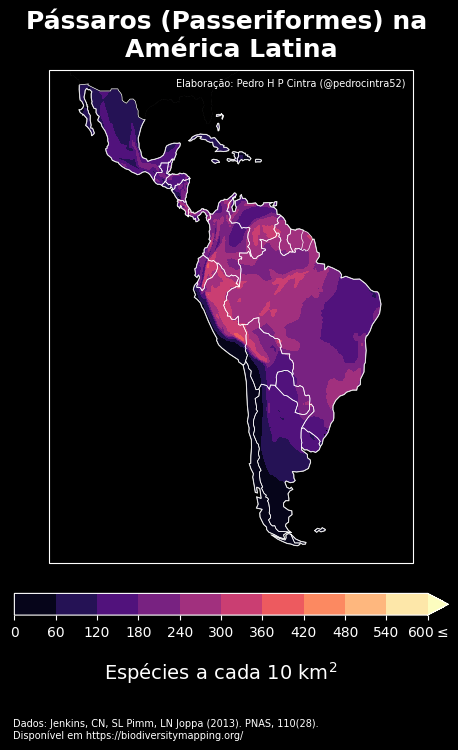

In [ ]:
lev = 20

projection = ccrs.EckertIV()
projection_name = 'EckertIV'

fig = plt.figure(figsize = (8, 8))

#####################################################
# TOP LEFT PLOT
#####################################################

#Add an axes to the current figure and make it the current axes.
ax = plt.subplot(111, projection = projection)

#make the map global rather than having it zoom in to extent of the plotted data
ax.set_global()

# ax.gridlines(linestyle = "--", color = "white")

ax.add_feature(cartopy.feature.LAND, facecolor='none', zorder = 2, edgecolor = 'white', lw = 1)

heat = ax.contourf(X_geo.T, Y_geo.T, msk_array, [60*i for i in range(11)], cmap = 'magma', extend = "max")
cb = plt.colorbar(heat, ax = ax,
                  orientation = "horizontal",
                  pad = 0.05,
                  aspect = 20,  #ratio of long to short dimension
                  shrink = 0.7)
cb.set_label(r"Espécies a cada 10 km$^2$", size = 14, rotation = 0, labelpad = 15,
            color = 'white')
cb.set_ticks([60*i for i in range(11)])
cb.set_ticklabels([60*i if i < 10 else r"600$\leq$" for i in range(11)], color = 'white')
cb.ax.tick_params(labelsize = 10, color = 'white')

#Add coastlines after filling contours
# ax.coastlines(resolution = "110m", lw = 2, color = 'white')
# ax.set_ylim(-60*max(ax.get_ylim())/90,80*max(ax.get_ylim())/90)

ax.add_feature(cartopy.feature.OCEAN, facecolor='black', zorder = 2)
world.loc[world['name'] == 'United States of America'].plot(facecolor = 'black', edgecolor='black', lw = 0.7, ax = ax,
                                                            zorder = 2)
world.loc[world["continent"] == "South America"].plot(facecolor = 'none', edgecolor='white', lw = 0.5, ax = ax,
                                                            zorder = 2)
world.loc[(world["continent"] == "North America") & (world["name"] != "United States of America")].plot(facecolor = 'none',
                                                                                                        edgecolor='white',
                                                                                                        lw = 0.5,
                                                                                                        ax = ax,
                                                                                                        zorder = 3)

ax.set_xlim(-11e6, -2.5e6)
ax.set_ylim(-7e6, 4.5e6)

plt.title("Pássaros (Passeriformes) na \nAmérica Latina", fontsize = 18, pad = 10, weight = 'bold',
          color = 'white')

fig.patch.set_facecolor('black')
for ax in fig.axes:
  ax.patch.set_facecolor('black')
  for spine in ax.spines.values():
        spine.set_edgecolor('white')

fig.text(0.24,0.07, "Dados: Jenkins, CN, SL Pimm, LN Joppa (2013). PNAS, 110(28). \nDisponível em https://biodiversitymapping.org/", color = 'white', fontsize = 7, va = 'top')
fig.text(0.73, 0.87, "Elaboração: Pedro H P Cintra (@pedrocintra52)", color = 'white', ha = 'right', fontsize = 7, va = 'top')

plt.savefig(f"Passeriformes_species_latin_america_magma_{projection_name}.png", dpi = 300, bbox_inches = 'tight')
plt.show()